In [1]:
import pandas as pd
import numpy as np
import re
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
#import pyLDAvis.gensim
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from gensim.models.phrases import Phrases, Phraser

pd.set_option("display.max_colwidth", 500)

%matplotlib inline

C:\Users\wongzn\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


# Reading Data

In [2]:
df = pd.read_csv('C:/Users/wongzn/Desktop/Transfer/df.csv')

In [3]:
df.head(3)

,Article Content,Article Link,Article Title,Topics
0,"SINGAPORE - A 21-year-old Malaysian suspect was arrested at the junction of Shenton Way and Maxwell Road last Thursday (Aug 1) after he allegedly disposed of a plastic bag containing 336g of Ice at a carpark in the vicinity of Orchard Towers. Officers from the Central Narcotics Bureau (CNB) had spotted him hopping onto his motorcycle in the carpark to make a hasty exit. They also recovered the plastic bag which contained 336g of Ice, valued at $33,000. This amount can feed the addiction of a...",https://www.straitstimes.com/singapore/suspected-drug-offender-arrested-at-shenton-way-junction-after-attempting-hasty-getaway-on,Malaysian drug suspect arrested at Shenton Way junction after attempting hasty getaway on motorbike,"CENTRAL NARCOTICS BUREAU, DRUG OFFENCES"
1,"SINGAPORE - When entering a pool of water, a person who does not know how to swim might not know to breathe in before entering, and to exhale slightly while submerged. As a result, it is possible he might inhale water while submerged. Forensic pathologist George Paul was pointing this out as he testified on Friday (June 14) in the ongoing trial of two commanders of the Singapore Civil Defence Force (SCDF) linked with the drowning of full-time national serviceman Corporal Kok Yuen Chin, which...",https://www.straitstimes.com/singapore/courts-crime/scdf-ragging-incident-non-swimmers-might-not-know-how-to-react-when-entering,"SCDF ragging death: Being submerged in dark, confined well could be dangerous even for a swimmer, says expert","SCDF, COURT TRIALS"
2,"SINGAPORE – The Republic should leverage on technology such as virtual simulation systems to better integrate people with special needs, including students, into society, said President Halimah Yacob. Speaking to reporters during a visit on Thursday (May 23) to Metta School, which caters to students from age 7 to 21 who have mild intellectual disability and autism, she said this should be done as part of the country’s Smart Nation push, which is a national effort to support better living usi...",https://www.straitstimes.com/singapore/education/use-technology-to-help-special-needs-students-integrate-as-part-of-smart-nation,Use technology to help people with special needs integrate as part of Smart Nation push: President Halimah,"SPECIAL NEEDS/SPECIAL EDUCATION, HALIMAH YACOB, SPECIAL EDUCATION SCHOOL, SMART CITIES"


In [4]:
def freq_words(x, terms=30):
    all_words =' '.join([text for text in x])
    all_words = all_words.split
    all_words = (x.lower for x in all_words)
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())})
    d = words_df.nlargest(columns="count",n=terms)
    plt.figure(figsize=(20,5))
    ax=sns.barplot(data=d,x="word",y="count")
    ax.set(ylabel='Count')
    plt.show()

# Preprocessing

In [5]:
def preprocess_content(column):
    #column = column.apply(lambda x: re.sub(r'SINGAPORE -', ' ', x))
    #column = column.apply(lambda x: re.sub(r'SINGAPORE', ' ', x, flags=re.IGNORECASE))
    column = column.apply(lambda x: re.sub(r'\([^)]*\)', '',x)) #remove (anything in brackets)
    column = column.apply(lambda x: re.sub(r'\d{2}[/-]\w{4}[/-]\w{3,4}', '',x)) #remove(xx-year-old)
    column = column.apply(lambda x: re.sub(r'straits times','',x, flags=re.IGNORECASE))
    column = column.apply(lambda x: re.sub(r'per cent','',x, flags=re.IGNORECASE))
    #column = column.apply(lambda x: re.sub(r'cpl kok yuen chin','',x, flags=re.IGNORECASE))
    #column = column.apply(lambda x: re.sub(r'cpl kok','',x, flags=re.IGNORECASE))
    #column = column.apply(lambda x: re.sub(r'[^a-zA-z\s]', ' ', x)) #removing digits and special characters (punctuations)
    #column = column.apply(lambda x: x.lower()) #convert to lowercase
    column = column.apply(lambda x: re.sub('\n','',x))
    return column

df['Article Content'] = preprocess_content(df['Article Content'])

In [6]:
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
add_words = ["singapore","said","also","year","month", "time", "last", "years"]
stop_words.update(add_words)

In [7]:
def tokenize_words(column):
    for word in column:
        yield(gensim.utils.simple_preprocess(str(word),deacc=True))

In [8]:
data_words = list(tokenize_words(df['Article Content']))

In [9]:
bigram = Phrases(data_words,min_count=3, threshold=100) #increasing threshold decreases phrases
trigram = Phrases(bigram[data_words], threshold=100)

In [10]:
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [11]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [12]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word.lower() not in stop_words] for doc in texts]

In [13]:
data_words_bigrams = make_bigrams(remove_stopwords(data_words))

In [14]:
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN','ADJ','VERB'])

In [15]:
data_words_nostops = remove_stopwords(data_lemmatized)

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# GridSearch Gensim

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(random_state=1, passes=100, alpha='auto',corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_nostops, start=5, limit=40, step=1)

In [20]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.424
Num Topics = 6  has Coherence Value of 0.4252
Num Topics = 7  has Coherence Value of 0.4411
Num Topics = 8  has Coherence Value of 0.4511
Num Topics = 9  has Coherence Value of 0.476
Num Topics = 10  has Coherence Value of 0.4656
Num Topics = 11  has Coherence Value of 0.4835
Num Topics = 12  has Coherence Value of 0.4672
Num Topics = 13  has Coherence Value of 0.5135
Num Topics = 14  has Coherence Value of 0.5146
Num Topics = 15  has Coherence Value of 0.4988
Num Topics = 16  has Coherence Value of 0.4747
Num Topics = 17  has Coherence Value of 0.4838
Num Topics = 18  has Coherence Value of 0.4707
Num Topics = 19  has Coherence Value of 0.4872
Num Topics = 20  has Coherence Value of 0.4847
Num Topics = 21  has Coherence Value of 0.4919
Num Topics = 22  has Coherence Value of 0.489
Num Topics = 23  has Coherence Value of 0.4921
Num Topics = 24  has Coherence Value of 0.4919
Num Topics = 25  has Coherence Value of 0.4857
Num Topics = 26  has 

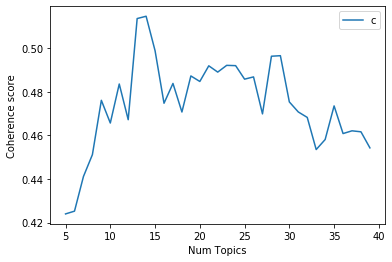

In [19]:
limit=40; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
#optimal_model.print_topics()

In [27]:
from gensim.test.utils import datapath

temp_file = datapath("C:/Users/wongzn/Desktop/LDA_model")
optimal_model.save(temp_file)
lda = gensim.models.ldamodel.LdaModel.load(temp_file)

# Getting Dominant Topic

In [28]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_lemmatized):
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [29]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_words_nostops)

In [30]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_view = pd.concat([df_dominant_topic,df['Topics']],axis=1)

In [53]:
df_view.Dominant_Topic.replace(0,'Unknown',inplace=True)
df_view.Dominant_Topic.replace(1,'Education and Community (Care and Support)',inplace=True)
df_view.Dominant_Topic.replace(2,'Issues in Society',inplace=True)
df_view.Dominant_Topic.replace(3,'Crime',inplace=True)
df_view.Dominant_Topic.replace(4,'Air and Road Transport',inplace=True)
df_view.Dominant_Topic.replace(5,'Diseases and Healthcare',inplace=True)
df_view.Dominant_Topic.replace(6,'Road Safety and PMD (Related News|Accidents)',inplace=True)
df_view.Dominant_Topic.replace(7,'Accidents',inplace=True)
df_view.Dominant_Topic.replace(8,'National Security and Global Issues',inplace=True)
df_view.Dominant_Topic.replace(9,'Employment and Technological Improvement',inplace=True)
df_view.Dominant_Topic.replace(10,'Crime (Cheat and Scams)',inplace=True)
df_view.Dominant_Topic.replace(11,'Housing and Living',inplace=True)
df_view.Dominant_Topic.replace(12,'Weather',inplace=True)
df_view.Dominant_Topic.replace(13,'Food, Water, Waste',inplace=True)
df_view.to_csv('C:/Users/wongzn/Desktop/LDA_topics.csv',index=False,header=True)

# Getting Topic Frequency

In [32]:
plot_topic = pd.DataFrame(df_view['Dominant_Topic'].value_counts())
plot_topic = plot_topic.rename_axis('Topic').reset_index()
plot_topic.rename(columns={'Dominant_Topic':'Freq'},inplace=True)
plot_topic['Perc'] = round((plot_topic.Freq/sum(plot_topic.Freq) * 100),2).astype(str) +'%'

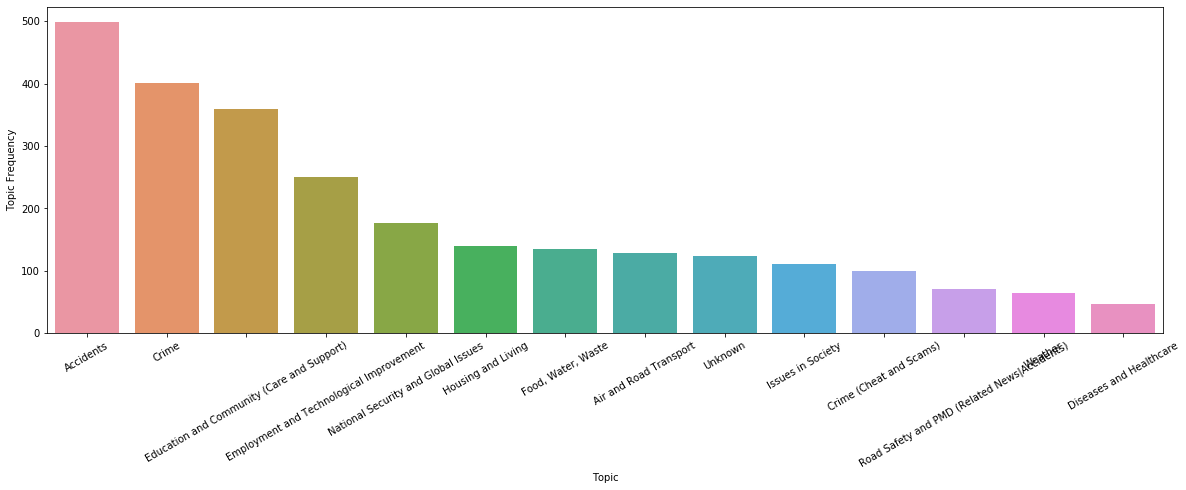

In [33]:
plt.figure(figsize=(20,6))
import seaborn as sns
ax=sns.barplot(data=plot_topic,x="Topic",y="Freq")
ax.set(ylabel='Topic Frequency')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

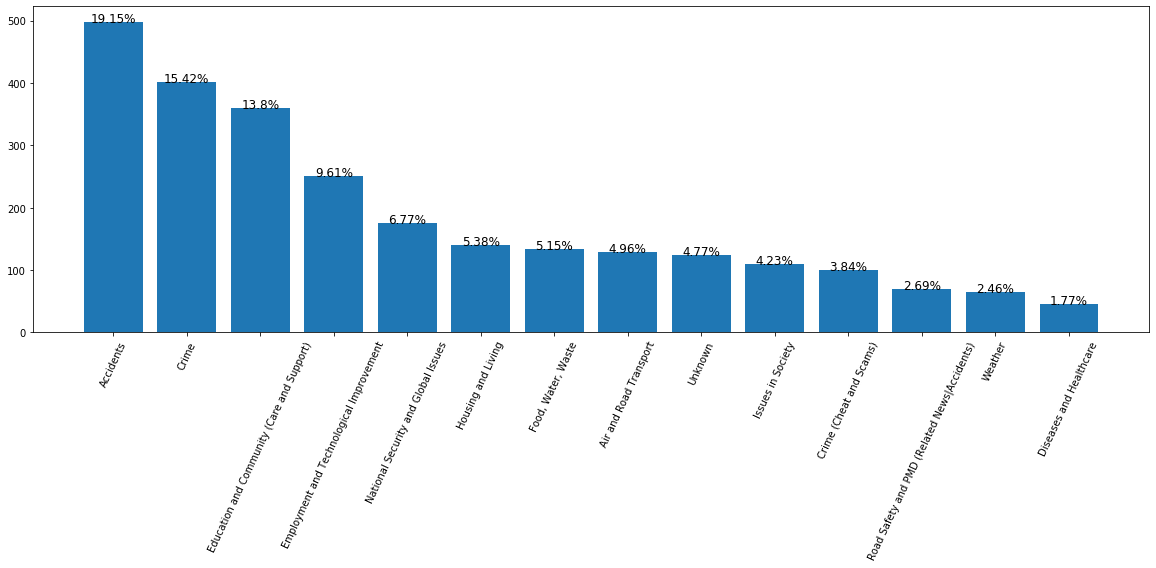

In [34]:
plt.figure(figsize=(20,6))
plt.bar(plot_topic['Topic'],plot_topic['Freq'])
plt.xticks(rotation=65)
for i in range(len(plot_topic)):
    plt.text(plot_topic.Topic[i],plot_topic.Freq[i], plot_topic.Perc[i], color='black', ha="center",size=12)
plt.show()

In [35]:
Article_content_clean = []

for i in range(len(data_words_nostops)):
    Article_content_clean.append(' '.join(data_words_nostops[i]))
df['clean_contents'] = Article_content_clean

In [36]:
#Saving LDA results for Supervised modelling
df_sup = pd.concat([df[['Article Title','clean_contents','Topics']],df_view[['Dominant_Topic']]],axis=1)
df_sup.rename(columns={'clean_contents':"Clean Contents",'Dominant_Topic':"Dominant Topic"},inplace=True)
df_sup.to_csv('C:/Users/wongzn/Desktop/topics.csv')

In [52]:
df_sup.head()

,Article Title,Clean Contents,Topics,Dominant Topic
0,Malaysian drug suspect arrested at Shenton Way junction after attempting hasty getaway on motorbike,malaysian suspect arrest junction shenton_way maxwell_road dispose contain ice carpark vicinity orchard_tower spot hop motorcycle carpark hasty exit recover contain ice value feed addiction abuser week offender include singaporean man arrest orchard_tower international building total seize singaporean malaysian suspect arrest late drug enforcement operation took_place offender arrest operation cover area include bedok bukit_merah tampine accord drug worth seize include ice heroin tablet substance bottle methadone,"CENTRAL NARCOTICS BUREAU, DRUG OFFENCES",Crime
1,"SCDF ragging death: Being submerged in dark, confined well could be dangerous even for a swimmer, says expert",enter pool water person know know breathe enter exhale submerge result possible inhale water submerge point testify ongoing trial commander civil_defence force link drown yuen_chin happen perform autopsy difference react prepare enter water unexpected event unexpected result startled inhalatory response cause person breathe water add common misconception enter body water float body float decomposition person presence mind tread water come water rush lung deep deep water come add cpl_kok malaysian national push tuas_view fire_station pump activity mark report date state die drown officer boon_lieutenant nazhan_mohame nazi officer rota_commander deputy_rota night incident charge hurt allegedly_faile group officer enter pump endanger life testify fifth day trial difference swimmer swimmer handle enter body water mention court know tell fellow scdf officer previous conversation dr_paul submerged pump dark confined_space disorient dangerous swimmer surface add opinion base conjecture au...,"SCDF, COURT TRIALS",Accidents
2,Use technology to help people with special needs integrate as part of Smart Nation push: President Halimah,technology system integrate people special_need include student society speak reporter visit school cater student age disability autism country smart_nation push national effort support live technology madam_halimah cite system available metta school motion sensor activate allow student experience everyday scenario example student practice thing making purchase supermarket stay safe environment technology assist student special_need learn independent visit different vocational facility school old student age receive school curriculum offer institute skill certification bake housekeeping operation prepare student certification enable seek education apply programme ite long meet requirement respective course student fold training room student pursue skill certificate housekeeping operation fourth visit school support student special_need visit madam_halimah hope employer willing provide opportunity student special_need exercise great patience flexibility training carry activity pre a...,"SPECIAL NEEDS/SPECIAL EDUCATION, HALIMAH YACOB, SPECIAL EDUCATION SCHOOL, SMART CITIES",Education and Community (Care and Support)
3,Work group's report aims to make medical disciplinary process fairer and faster,group task improve medical watchdog look sit judge permanent team senior retire doctor judge disciplinary case screener ensure system bogge frivolous complaint want set timeline follow step complaint process extension obtain limit tell member press sideline meeting doctor timeline place member person work group comprise lawyer medical professional lay people adhere state present meeting novena told_reporter long delay hear case acceptable justice delay deny work group meet doctor private hospital public cluster plan talk patient advocacy group medical specialist medicine draft report end work group set look issue disciplinary judgment doctor arm case doctor fine tell patient effect case doctor fine release information patient check caller phone husband group clarify constitute reason disciplinary hea

# Creating A Supervised Model For Topic Modelling From LDA Topics

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Train_X,Test_X,Train_Y,Test_Y = model_selection.train_test_split(df_sup['Clean Contents'],df_sup['Dominant Topic'],
                                                                 test_size=0.3,random_state=100)

In [38]:
Tfidf_vect = TfidfVectorizer(lowercase=True, min_df=5,max_df=0.9)
Tfidf_vect.fit(df_sup['Clean Contents'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [39]:
knn=KNeighborsClassifier(n_neighbors=14)
knn.fit(Train_X_Tfidf,Train_Y)
knn_predictions = knn.predict(Test_X_Tfidf)
print("KNN Accuracy Score -> ",accuracy_score(knn_predictions, Test_Y)*100)

KNN Accuracy Score ->  73.36747759282972


In [40]:
print(confusion_matrix(Test_Y,knn_predictions))
print(classification_report(Test_Y,knn_predictions))

[[146   1   4   0   0   1   0   0   0   0   0   2   0   2]
 [  2  27   8   0   0   0   1   0   0   0   1   1   1   0]
 [ 12   5  96   2   1   2   6   0   2   0   0   2   0   0]
 [  1   0  11  15   0   1   0   0   1   0   0   0   0   0]
 [  0   1   1   0   6   4   1   0   0   0   0   0   0   0]
 [  8   0   3   0   0  82   4   1   1   0   1   0   0   3]
 [  2   2   3   0   0   9  46   1   2   0   1   0   1   0]
 [  2   1   0   0   0   3   4  31   0   0   0   0   0   2]
 [  3   2   3   2   1   2   3   0  18   0   1   1   0   0]
 [  3   0   6   0   0  11   0   0   0  18   2   1   1   0]
 [  0   4   1   0   0   3   1   2   0   0  43   0   0   0]
 [  5   1   1   0   0   0   0   1   0   0   0  12   0   0]
 [  2   0   0   0   0   7   2   0   2   0   2   0  15   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0  18]]
                                              precision    recall  f1-score   support

                                   Accidents       0.78      0.94      0.85       156


In [41]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

predictions_NB = Naive.predict(Test_X_Tfidf)
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)
print(classification_report(Test_Y,predictions_NB))

Naive Bayes Accuracy Score ->  64.40460947503202


C:\Users\wongzn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                              precision    recall  f1-score   support

                                   Accidents       0.68      0.99      0.81       156
                      Air and Road Transport       1.00      0.17      0.29        41
                                       Crime       0.62      0.87      0.73       128
                     Crime (Cheat and Scams)       0.00      0.00      0.00        29
                     Diseases and Healthcare       0.00      0.00      0.00        13
  Education and Community (Care and Support)       0.52      0.95      0.67       103
    Employment and Technological Improvement       0.53      0.70      0.60        67
                          Food, Water, Waste       1.00      0.19      0.31        43
                          Housing and Living       1.00      0.33      0.50        36
                           Issues in Society       1.00      0.12      0.21        42
         National Security and Global Issues       0.

In [42]:
from sklearn import tree
tree = tree.DecisionTreeClassifier(random_state = 21)
tree.fit(Train_X_Tfidf,Train_Y)
tree_prediction = tree.predict(Test_X_Tfidf)

print("Tree Accuracy Score -> ",accuracy_score(Test_Y,tree_prediction)*100)
print(classification_report(Test_Y,tree_prediction))

Tree Accuracy Score ->  50.96030729833547
                                              precision    recall  f1-score   support

                                   Accidents       0.68      0.67      0.67       156
                      Air and Road Transport       0.48      0.49      0.48        41
                                       Crime       0.54      0.60      0.57       128
                     Crime (Cheat and Scams)       0.37      0.24      0.29        29
                     Diseases and Healthcare       0.27      0.31      0.29        13
  Education and Community (Care and Support)       0.56      0.62      0.59       103
    Employment and Technological Improvement       0.42      0.46      0.44        67
                          Food, Water, Waste       0.46      0.30      0.37        43
                          Housing and Living       0.41      0.44      0.43        36
                           Issues in Society       0.36      0.21      0.27        42
         Na

In [43]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(multi_class='multinomial',solver='newton-cg')
LR.fit(Train_X_Tfidf,Train_Y)
pred_LR = LR.predict(Test_X_Tfidf)

print("LR Accuracy Score -> ",accuracy_score(pred_LR, Test_Y)*100)
print(classification_report(Test_Y,pred_LR))

LR Accuracy Score ->  78.61715749039692
                                              precision    recall  f1-score   support

                                   Accidents       0.87      0.97      0.92       156
                      Air and Road Transport       0.77      0.59      0.67        41
                                       Crime       0.70      0.93      0.80       128
                     Crime (Cheat and Scams)       1.00      0.45      0.62        29
                     Diseases and Healthcare       0.75      0.23      0.35        13
  Education and Community (Care and Support)       0.67      0.92      0.78       103
    Employment and Technological Improvement       0.72      0.81      0.76        67
                          Food, Water, Waste       0.88      0.65      0.75        43
                          Housing and Living       0.85      0.64      0.73        36
                           Issues in Society       1.00      0.40      0.58        42
         Nati

In [44]:
SVM = svm.SVC(C=1.6, kernel='linear',degree=3,random_state=1)
SVM.fit(Train_X_Tfidf,Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)


print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
print(confusion_matrix(Test_Y,predictions_SVM))
print(classification_report(Test_Y,predictions_SVM))

SVM Accuracy Score ->  81.17797695262485
[[145   3   4   0   0   0   0   0   0   0   0   1   1   2]
 [  1  31   4   0   0   2   2   0   0   0   0   1   0   0]
 [  6   2 107   3   1   1   2   1   3   0   0   2   0   0]
 [  2   0   9  17   0   0   0   0   1   0   0   0   0   0]
 [  0   1   0   0   8   3   0   0   0   0   0   0   0   1]
 [  3   0   2   0   0  87   4   1   2   1   1   0   1   1]
 [  1   2   1   0   1   3  55   2   0   0   1   0   1   0]
 [  1   2   1   0   0   1   4  33   0   0   0   0   0   1]
 [  1   1   2   0   0   2   0   0  30   0   0   0   0   0]
 [  2   0   2   0   0   8   1   0   0  27   1   1   0   0]
 [  1   3   1   0   0   1   1   2   0   2  43   0   0   0]
 [  2   0   1   0   0   0   0   1   0   0   0  16   0   0]
 [  1   0   0   0   0   5   1   0   1   1   1   0  20   0]
 [  1   0   1   0   0   0   1   0   1   0   0   0   0  15]]
                                              precision    recall  f1-score   support

                                   Accidents 

# Feeding in New Data (Test Dataset)

In [45]:
test = pd.read_csv('C:/Users/wongzn/Desktop/Transfer/ST_63.csv')
test['Article Content'] = test['Article Content'].astype(str)

#Preprocess the test set

test['Article Content'] = preprocess_content(test['Article Content'])
data_words_test = list(tokenize_words(test['Article Content']))
data_words_bigrams_test = make_bigrams(remove_stopwords(data_words_test))
data_lemmatized_test = lemmatization(data_words_bigrams_test, allowed_postags=['NOUN', 'ADJ', 'VERB'])
data_words_nostops_test = remove_stopwords(data_lemmatized_test)

Article_content_clean = []
for i in range(len(data_words_nostops_test)):
    Article_content_clean.append(' '.join(data_words_nostops_test[i]))
test['clean_contents'] = Article_content_clean

In [46]:
Train_X = df_sup['Clean Contents']
Test_X = test['clean_contents']
Train_Y = df_sup['Dominant Topic']

In [47]:
Tfidf_vect = TfidfVectorizer(lowercase=True, min_df=5,max_df=0.9)
Tfidf_vect.fit(Train_X)

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [48]:
SVM = svm.SVC(C=1.6, kernel='linear', degree=3,gamma=0.01,random_state=1,probability=True)
SVM.fit(Train_X_Tfidf,Train_Y)

#predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
pred_prob = SVM.predict_proba(Test_X_Tfidf)

In [49]:
pred_probability = []
for i in range(len(pred_prob)):
    pred_probability.append(sorted(pred_prob[i], reverse=True)[0])

In [50]:
test_check = pd.concat([test[['Article Title','clean_contents','Topics']],pd.DataFrame(predictions_SVM),pd.DataFrame(pred_probability)], axis=1,ignore_index=True)
test_check = test_check.rename(columns={0:"Article Title",1:"Clean Contents",2:"Straits Times Topics",3:"LDA Model Predictions",4:"Probability"})

In [51]:
pd.set_option("display.max_colwidth", 1000)
test_check['LDA Model Predictions'] = test_check['LDA Model Predictions'].str.upper()
test_check.iloc[[0,2,13,18,62]]

,Article Title,Clean Contents,Straits Times Topics,LDA Model Predictions,Probability
0,Seafood restaurant in Punggol stops using live crab claw machine after public outcry,stop machine customer catch live crab stop machine apologise cause public unhappiness gimmick turn come day society prevention cruelty animal cruel crab machine inflict unnecessary harm distress drop height claw intend use animal play thing notice lot child settlement want educate chief_executive stress team planning come design machine harm hurt crab sorry apologise inconvenience unhappiness cause tell respect feedback public truly_sorry animal lover spca jaipal feel measure insufficient appreciate clarification news ask permanent stop use machine tell spark public outcry restaurant introduce machine early customer pay snap desire crustacean machine believe introduce customer accord restaurant tank hold crab elevate cushion crab fall snap drop impact crab pincer tie crustacean replace new lot hour machine launch customer catch crab customer try fail,"ANIMALS, RESTAURANTS/EATERIES",CRIME,0.347352
2,Skills framework launched for workplace safety and health officers,health officer clear idea skill need job progress career skill framework officer launch health officer conference hold framework provide key information health sector career pathway available industry possible job role highlight exist emerging_skill competency require provide list training programme skill upgrade framework plan career development company benefit term competency base recruitment effective training plan framework skillsfuture employer industry association education training provider guide career register health officer number triple officer come expect number register officer stabilise economy timely shift focus enhance skillset help effective officer critical help achieve health goal outline plan add plan lay strategy country safest healthy workplace target reduce workplace fatal_injury rate worker clear officer critical noble job line protect worker ground mitigate hazard create safe workplace line reach boardroom organisation exercise influence employer value inve...,"WORKPLACE SAFETY AND HEALTH, JOSEPHINE TEO",EMPLOYMENT AND TECHNOLOGICAL IMPROVEMENT,0.997641
13,SUTD students challenged to turn problems into opportunities through interdisciplinary studies,technology design challenge keat nation design study turn national global challenge opportunity speak university student curriculum integrate system design thinking place help deal challenge climate_change grow economy harness diversity building look achieve short achieve world design challenge nation design significant change come way turn change opportunity education major social leveller singaporean decade country rapid progress education highlight report release ministry finance today educate able find job earn education achieve maximise value spend field dollar count add invest education expand university sector add diversity offering provide pathway student cater strength passion establish decade fourth student curriculum infuse design course specialisation area architecture sustainable design engineering product development engineering system design information system technology design technological advancement design graduate seek employer today event hotel announce offer s...,"HENG SWEE KEAT, EDUCATION AND SCHOOLS, SINGAPORE UNIVERSITY OF TECHNOLOGY AND DESIGN",EMPLOYMENT AND TECHNOLOGICAL IMPROVEMENT,0.977796
18,Devotee in stable condition after falling into fire pit while fulfilling vows: HEB and temple,trip fall fire pit fulfilling vow rescuer attend devotee medical team rush management visit hospital continue people help suffer injury incident recover heb detail available heb want privacy prayer family wish thank provide need support ensure devotee receive possible heb temple,"RELIGION, HINDUISM",EDUCATION AND COMMUNITY (CARE AND SUPPORT),0.682417
62,GrabFood looking into video of delivery rider using PMD on PIE,del